In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

## Global Variables

In [2]:
DEBUG = True
ym_per_pix = 30/720
xm_per_pix = 3.7/700

## Utility Functions

In [3]:
def save_to_output(img, original_file, subdir, base_name):
    if DEBUG:
        subdir_path = "output_images/{}".format(subdir)
        if not os.path.exists(subdir_path):
            os.mkdir(subdir_path)

        output_file = os.path.join(subdir_path,"{}_{}".format(base_name, os.path.basename(original_file)))
        mpimg.imsave(output_file, img)
    
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


def vconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(im.shape[1] for im in im_list)
    im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation)
                      for im in im_list]
    return cv2.vconcat(im_list_resize)


def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)


def concat_tile_resize(im_list_2d, interpolation=cv2.INTER_CUBIC):
    im_list_v = [hconcat_resize_min(im_list_h, interpolation=cv2.INTER_CUBIC) for im_list_h in im_list_2d]
    return vconcat_resize_min(im_list_v, interpolation=cv2.INTER_CUBIC)


def bin_to_img(binary):
    return np.dstack((binary, binary, binary)) * 255

## Camera Calibration

In [4]:
images = glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6
objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for image_file in images:
    img = mpimg.imread(image_file)
    gray = grayscale(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    corners_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    save_to_output(corners_img, image_file, "camera_calibration", "calibrated")
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Perspective Transform

Text(0.5, 1.0, 'Warped')

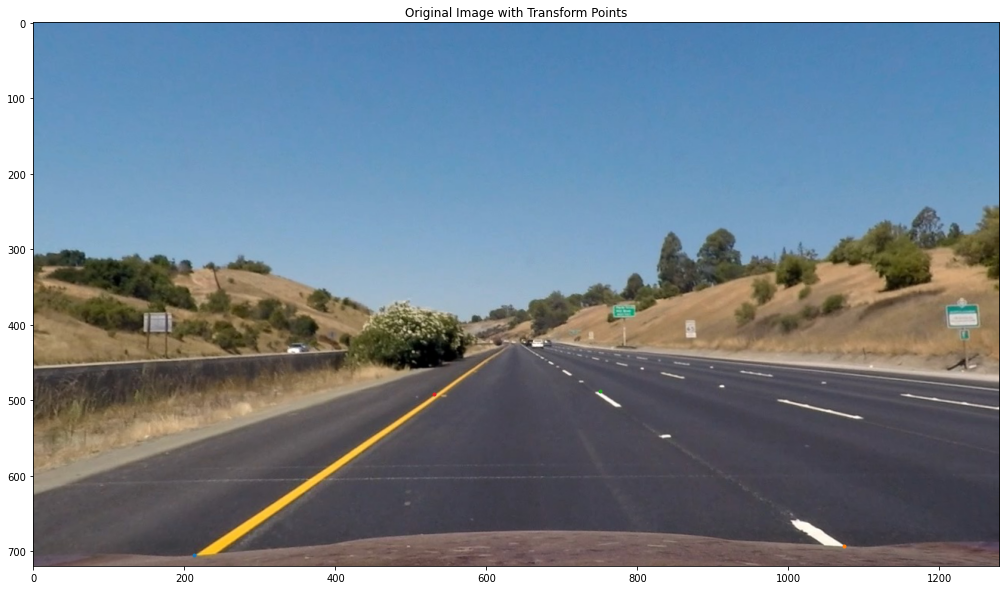

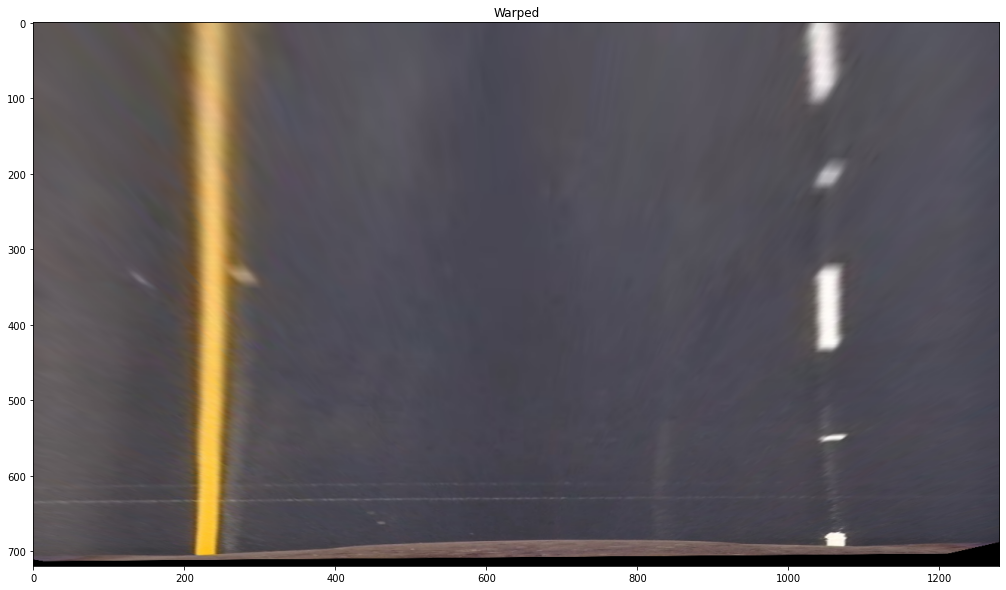

In [5]:
straight_img = mpimg.imread("test_images/straight_lines1.jpg")
undistorted = undistort(straight_img, mtx, dist)
undistorted_size = (undistorted.shape[1], undistorted.shape[0])
fig = plt.figure(figsize=(20,10))
plt.imshow(undistorted)
plt.plot(213, 705, ".")
plt.plot(1074, 693, ".")
plt.plot(750, 488, ".")
plt.plot(531, 492, ".")
plt.title('Original Image with Transform Points')

src = np.float32([[213, 705], [1074, 693], [750, 488], [531, 492]])
dest = np.float32([[213, 705], [1074, 693], [1074, 317], [213, 317]])
M = cv2.getPerspectiveTransform(src, dest)
warped = cv2.warpPerspective(undistorted, M, undistorted_size, flags=cv2.INTER_LINEAR)
fig = plt.figure(figsize=(20,10))
plt.imshow(warped)
plt.title('Warped')

## Representing Lane Lines

In [13]:
from collections import deque

class Line():
    def __init__(self):
        self.fitx_buffer = deque(maxlen=10)
        self.fitx_m_buffer = deque(maxlen=10)
        self.fail_count = 0
        
    def add_line(self, fitx, fitx_m):
        self.fail_count = 0
        self.fitx_buffer.append(fitx)
        self.fitx_m_buffer.append(fitx_m)
    
    # Get average of (up to) the last 10 lines, in pixels
    def get_avg_fit(self):
        return np.mean(self.fitx_buffer, axis=0)
    
    # Get average of (up to) the last 10 lines in meters
    def get_avg_fit_m(self):
        return np.mean(self.fitx_m_buffer, axis=0)
    
    # The the radius of the line at the y-point: y_eval (in meters)
    def get_radius(self, y_eval):
        fit_m = self.get_avg_fit_m()
        return ((1+((2*fit_m[0]*y_eval*ym_per_pix)+fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
    
    def line_found(self):
        return len(self.fitx_buffer) > 0
    
    # Returns true if the line exists and there have been fewer than 10 repeat errors
    def healthy(self):
        return self.line_found() and self.fail_count < 10
    
    
def lines_parallel(fitx_a, fitx_b, y_step):
    line_a, ploty_a = get_points_for_poly(fitx_a, y_step)
    line_b, ploty_b = get_points_for_poly(fitx_b, y_step)
    std =  np.std(line_a - line_b)
    return std < 100

## Lane Line Finding

In [7]:
def fit_poly(leftx, lefty, rightx, righty):
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2) 
    except:
        return False, None, None, None, None
    
    return True, left_fit, left_fit_m, right_fit, right_fit_m


def get_points_for_poly(fit, y_step):
    ploty = np.linspace(0, y_step - 1, y_step)
    fitx = fit[0]*(ploty**2) + fit[1]*ploty + fit[2]
    return fitx, ploty


def find_lane_pixels(thresh_binary):
    out_img = np.dstack((thresh_binary, thresh_binary, thresh_binary)) * 255
    left_lane_inds = []
    right_lane_inds = []
    histogram = np.sum(thresh_binary[thresh_binary.shape[0]//2:,:], axis=0)
    midpoint=int(histogram.shape[0]//2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = int(thresh_binary.shape[0]//nwindows)
    nonzero=thresh_binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(nwindows):
        win_y_low = thresh_binary.shape[0] - (window+1)*window_height
        win_y_high = thresh_binary.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))  
        
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return fit_poly(leftx, lefty, rightx, righty)


def search_around_poly(thresh_binary, left_fitx, right_fitx):
    nonzero = thresh_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    
    left_lane_inds = ((nonzerox > (left_fitx[0]*(nonzeroy**2) + left_fitx[1]*nonzeroy + left_fitx[2] - margin)) & \
                      (nonzerox < (left_fitx[0]*(nonzeroy**2) + left_fitx[1]*nonzeroy + left_fitx[2] + margin)))
    
    right_lane_inds = ((nonzerox > (right_fitx[0]*(nonzeroy**2) + right_fitx[1]*nonzeroy + right_fitx[2] - margin)) & \
                       (nonzerox < (right_fitx[0]*(nonzeroy**2) + right_fitx[1]*nonzeroy + right_fitx[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return fit_poly(leftx, lefty, rightx, righty)

## Calculating Distance from Lane Center

In [8]:
def get_distance_from_center(x_min, x_max, fit_l, fit_r, y_eval):
    x_l = fit_l[0]*(y_eval**2) + fit_l[1]*y_eval + fit_l[2]
    x_r = fit_r[0]*(y_eval**2) + fit_r[1]*y_eval + fit_r[2]
    
    return ((x_l - x_min) - (x_max - x_r)) / 2

## Color and Gradient Threshold

In [9]:
def sorbelx(img, sx_thresh):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return sxbinary

def hsv_mask(img):
    # Select Yellow
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_lower = np.array([20, 50, 150])
    yellow_upper = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    yellow_filter = cv2.bitwise_and(hsv, hsv, mask=yellow_mask)
    yellow_gray = cv2.cvtColor(cv2.cvtColor(yellow_filter, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2GRAY)
    yellow_thresh = (20, 255)
    yellow_binary = np.zeros_like(yellow_gray)
    yellow_binary[(yellow_gray > yellow_thresh[0]) & (yellow_gray <= yellow_thresh[1])] = 1
    
    # Select White
    white_lower = np.array([0, 0, 200])
    white_upper = np.array([255, 30, 255])
    white_mask = cv2.inRange(hsv, white_lower, white_upper)
    white_filter = cv2.bitwise_and(hsv, hsv, mask=white_mask)
    white_gray = cv2.cvtColor(cv2.cvtColor(white_filter, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2GRAY)
    white_thresh = (20, 255)
    white_binary = np.zeros_like(white_gray)
    white_binary[(white_gray > white_thresh[0]) & (white_gray <= white_thresh[1])] = 1
    
    color_binary = cv2.bitwise_or(yellow_binary, white_binary)
    
    return color_binary

## Image Pipeline

In [12]:
def pipeline(img, left_line, right_line, debug=False):
    sx_thresh=(60, 255)
    
    # Undistort image
    img = np.copy(img)
    undistorted = undistort(img, mtx, dist)
        
    # Apply birdseye perspective change
    img_size = (undistorted.shape[1], undistorted.shape[0])
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Color Thresholding
    color_binary = hsv_mask(undistorted)
    color_binary_warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Gradient Thresholding
    sxbinary = sorbelx(grayscale(undistorted), sx_thresh)
    sxbinary_warped = cv2.warpPerspective(sxbinary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Combine Color and Gradient into single binary output
    thresh_binary = np.zeros_like(color_binary_warped)
    thresh_binary[(color_binary_warped == 1) | (sxbinary_warped == 1)] = 1
    
    # If a line exists and there aren't repeat errors, search around last line
    if left_line.healthy() and right_line.healthy():
        fitted, left_fit, left_fit_m, right_fit, right_fit_m = search_around_poly(thresh_binary, left_line.get_avg_fit(), right_line.get_avg_fit()) 
    # Otherwise, apply window search
    else:
        fitted, left_fit, left_fit_m, right_fit, right_fit_m = find_lane_pixels(thresh_binary)
    
    # If lines are parallel, save results in line buffers
    if fitted and lines_parallel(left_fit, right_fit, thresh_binary.shape[0]):
        left_line.add_line(left_fit, left_fit_m)
        right_line.add_line(right_fit, right_fit_m)
    else:
        left_line.fail_count += 1
        right_line.fail_count += 1
       
    lane_region = np.zeros_like(undistorted)
    avg_curve = 0
    center_dist = 0
    if left_line.line_found() and right_line.line_found():
        # Draw lane region
        left_fitx, ploty_left = get_points_for_poly(left_line.get_avg_fit(), thresh_binary.shape[0])
        right_fitx, ploty_right = get_points_for_poly(right_line.get_avg_fit(), thresh_binary.shape[0])
        left_pts = np.column_stack((left_fitx, ploty_left))
        right_pts = np.flipud(np.column_stack((right_fitx, ploty_right)))
        window_pts = np.int_([np.concatenate((left_pts, right_pts))]) 
        cv2.fillPoly(lane_region, window_pts, (0, 255, 0))
        
        # Calculate curve radius
        y_eval = np.max(ploty_left) * ym_per_pix
        left_curve = left_line.get_radius(y_eval)
        right_curve = right_line.get_radius(y_eval)
        avg_curve = (left_curve + right_curve) // 2
        
        # Get distance from center
        x_max = thresh_binary.shape[1] * xm_per_pix
        center_dist = get_distance_from_center(0, x_max, left_line.get_avg_fit_m(), right_line.get_avg_fit_m(), y_eval)
    
    # Return to normal perspective
    lane_region_unwarped = cv2.warpPerspective(lane_region, np.linalg.inv(M), img_size, flags=cv2.INTER_LINEAR)
    
    # Annotate Lane Curvature
    curve_txt = "Lane Curvature: {:.2f}m".format(avg_curve)
    cv2.putText(lane_region_unwarped, curve_txt, (40,80), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,0,0), 2, cv2.LINE_AA)
    
    # Annotate Center Distance
    center_txt = "Distance from Center: {:.3f}m".format(center_dist)
    cv2.putText(lane_region_unwarped, center_txt, (40,140), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,0,0), 2, cv2.LINE_AA)
    lane_lines =  weighted_img(lane_region_unwarped, undistorted)
    
    # Create composite image
    threshold_img = np.dstack((sxbinary, color_binary, np.zeros_like(color_binary))) * 255
    cv2.putText(threshold_img, "Sorbel Lines", (40,80), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(threshold_img, "Color Threshold", (40,140), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255,0), 2, cv2.LINE_AA)

    warped_threshold_img = bin_to_img(thresh_binary)
    cv2.putText(warped_threshold_img, "Birdseye Binary Threshold", (40,80), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,0,0), 2, cv2.LINE_AA)
    return concat_tile_resize([[lane_lines], [threshold_img, warped_threshold_img]])

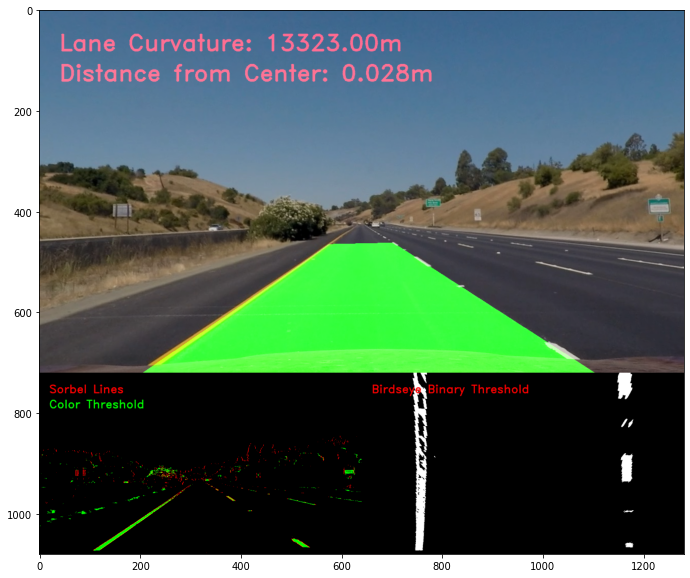

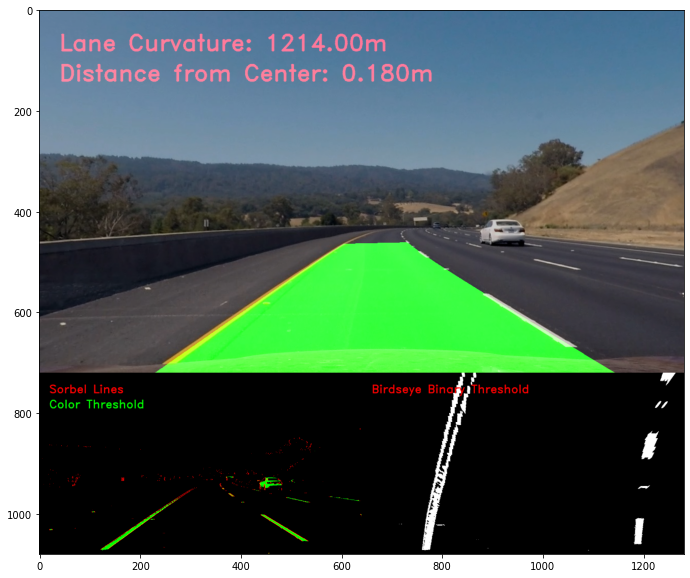

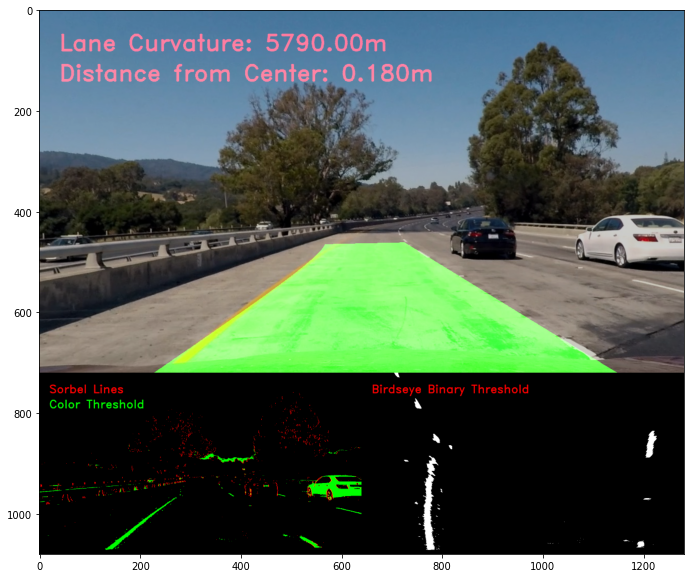

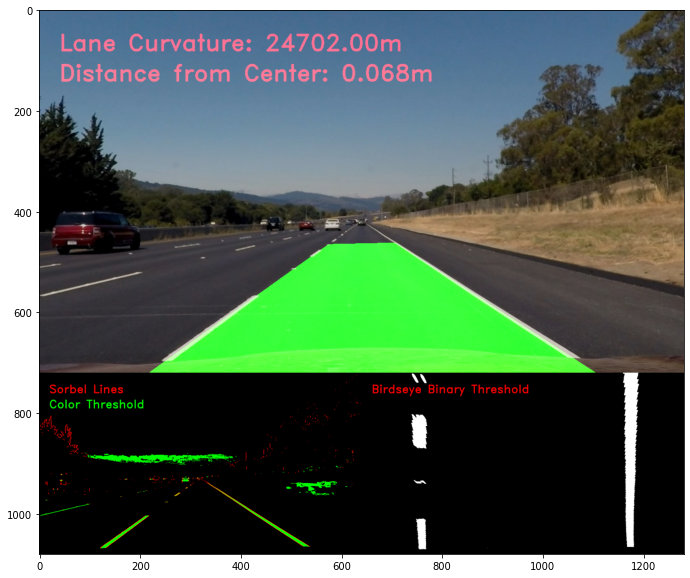

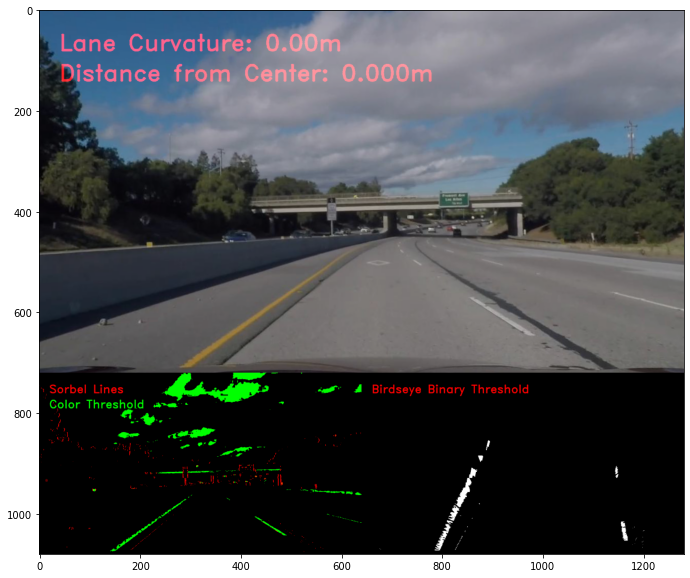

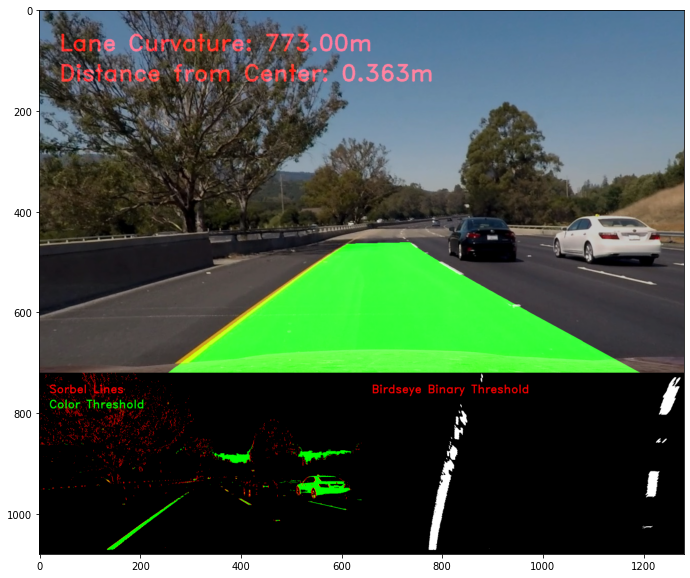

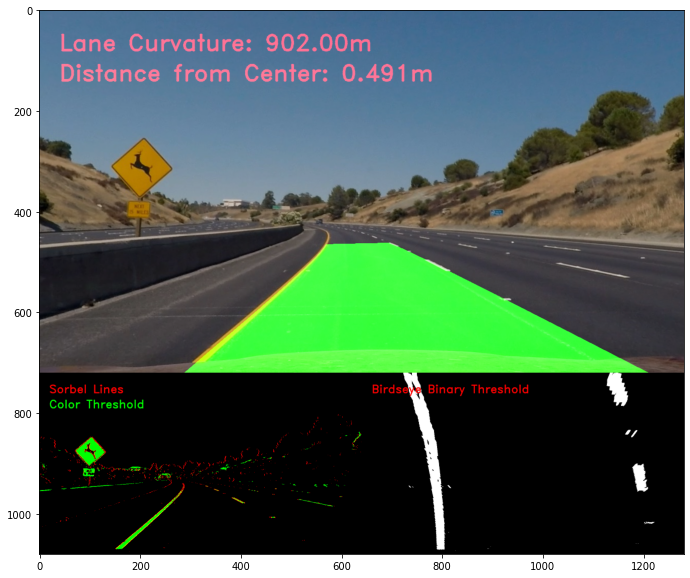

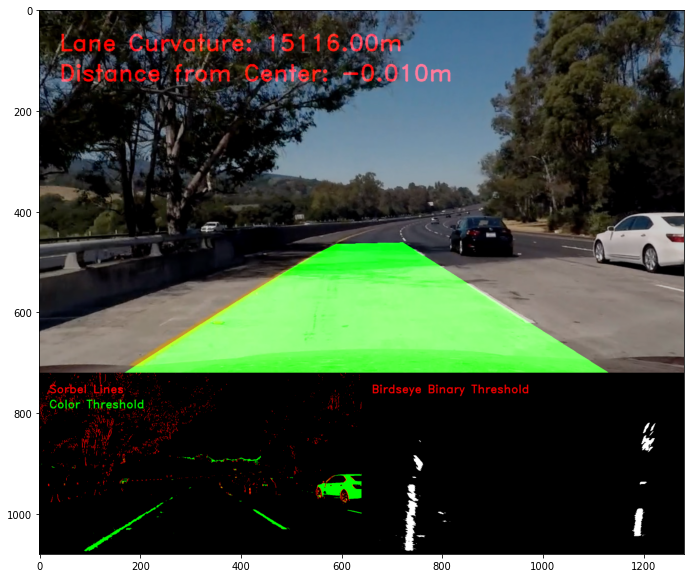

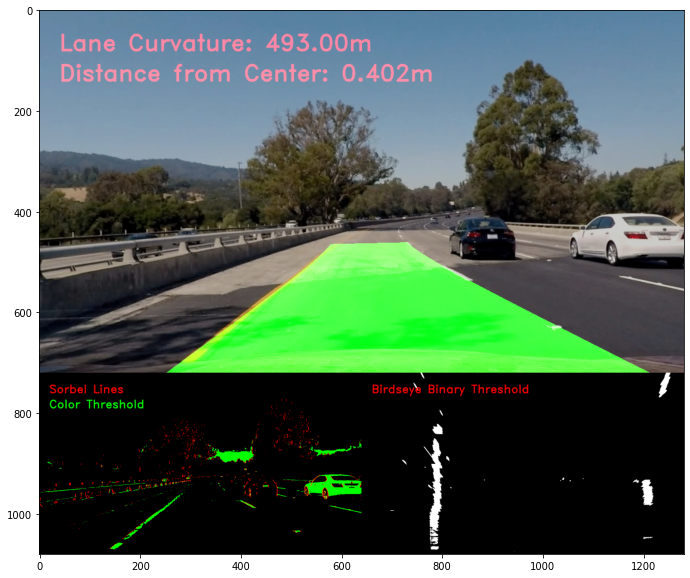

In [14]:
# Test the pipline on images in the test_images directory
test_images = glob.glob('./test_images/*.jpg')
for img_file in test_images:
    img = mpimg.imread(img_file)
    result = pipeline(img, left_line = Line(), right_line = Line(), debug=True)
    fig = plt.figure(figsize=(20,10))
    plt.imshow(result)

## Video Pipelines

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image, left_line, right_line):
    result = pipeline(image, left_line=left_line, right_line=right_line)
    return result

In [17]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
left_line = Line()
right_line = Line()
white_clip = clip1.fl_image(lambda im: process_image(im, left_line, right_line)) #NOTE: this function expects color images!!
%time white_clip.write_videofile("output_videos/project.mp4", audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project.mp4.
Moviepy - Writing video output_videos/project.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project.mp4
CPU times: user 3min 16s, sys: 1min 14s, total: 4min 30s
Wall time: 1min 55s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/project.mp4"))

In [784]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
left_line = Line()
right_line = Line()
challenge_clip = clip2.fl_image(lambda im: process_image(im, left_line, right_line)) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile("output_videos/challenge.mp4", audio=False)

t:   1%|          | 3/485 [00:00<00:23, 20.50it/s, now=None]

Moviepy - Building video output_videos/challenge.mp4.
Moviepy - Writing video output_videos/challenge.mp4




t:  51%|█████     | 248/485 [00:21<00:20, 11.83it/s, now=None]


t:  99%|█████████▉| 479/485 [00:42<00:00, 12.45it/s, now=None]


t:  28%|██▊       | 134/485 [10:35<00:25, 13.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready output_videos/challenge.mp4
CPU times: user 1min 14s, sys: 28.1 s, total: 1min 42s
Wall time: 43.6 s


In [783]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/challenge.mp4"))